In [1]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit 
from tqdm import tqdm
from numba import jit
import pandas as pd

from aRead import readAREPO, readSinks
import constants as c
matplotlib.rcParams.update({'figure.dpi': 150})

### Sink Particle Mass Function

In [ ]:
# Load in the sink data 
uv1s = readSinks(1, "/UV1/sink_snap_074")
print(np.sum(uv1s.sinkMass))
uv10s = readSinks(1, "/UV10/sink_snap_079")
print(np.sum(uv10s.sinkMass))
uv100s = readSinks(1, "/UV100/sink_snap_087")
print(np.sum(uv100s.sinkMass))
uv1000s = readSinks(1, "/UV1000/sink_snap_070")
print(np.sum(uv1000s.sinkMass))

uv1crs = readSinks(1, "/UV1attenuated/sink_snap_074")
uv1000crs = readSinks(1, "/UV1000attenuated/sink_snap_063")
print(np.sum(uv1crs.sinkMass))
print(np.sum(uv1000crs.sinkMass))

3186.865113185607
3060.5706302062745
3149.4976140667122
3086.55691008572
3123.8388406244694
3331.627669062933


In [3]:
# Create the bins to plot against
bins = np.linspace(np.min(np.log10(uv1s.sinkMass)), np.max(np.log10(uv1000s.sinkMass)), 25)

# Log all sink masses
m1 = np.log10(uv1s.sinkMass)
m2 = np.log10(uv10s.sinkMass)
m3 = np.log10(uv100s.sinkMass)
m4 = np.log10(uv1000s.sinkMass)

# Saltpeter fit function
def func(x, a, b):
    return b * (x**a)

# Get true masses and bins, not log
m1 = 10**m1
m2 = 10**m2
m3 = 10**m3
m4 = 10**m4
bins = 10**bins

In [4]:
def getIMFStats(data):
    print(np.mean(data.sinkMass))
    print(np.median(data.sinkMass))
    
    totalMass = np.sum(data.sinkMass)
    mass = np.array(data.sinkMass)
    print(100*np.sum(mass[mass<1])/totalMass)
    print(100*np.sum(mass[mass>10])/totalMass)
    
getIMFStats(uv1crs)

1.5456896786860315
0.6784968055404899
20.36733330025357
23.863528564594986


In [5]:
# Fit a line of best-fit
def powerLawFit(x, alpha, beta):
    return x * alpha + beta

x = np.linspace(0, 2, 100)

def jeansMass(density, temperature, mu=2.4):
    return ((np.pi * c.kB() / c.G())**(3/2) * (temperature**3 / (mu**4 * c.mProt()**4 * density))**(1/2)) / 1.991e33

[-1.39246018  2.76846953] [0.13194488 0.15170621]
[-1.25341723  2.6639768 ] [0.08230542 0.09747166]
[-0.93791072  2.35642296] [0.08157949 0.09466149]
[-0.86348431  2.24856834] [0.08867369 0.11194876]
[-0.82584066  2.16785963] [0.0484039 0.0612866]
[-0.70254124  1.98138511] [0.04388195 0.05766818]


Text(0.08, 0.5, 'Number of Sinks')

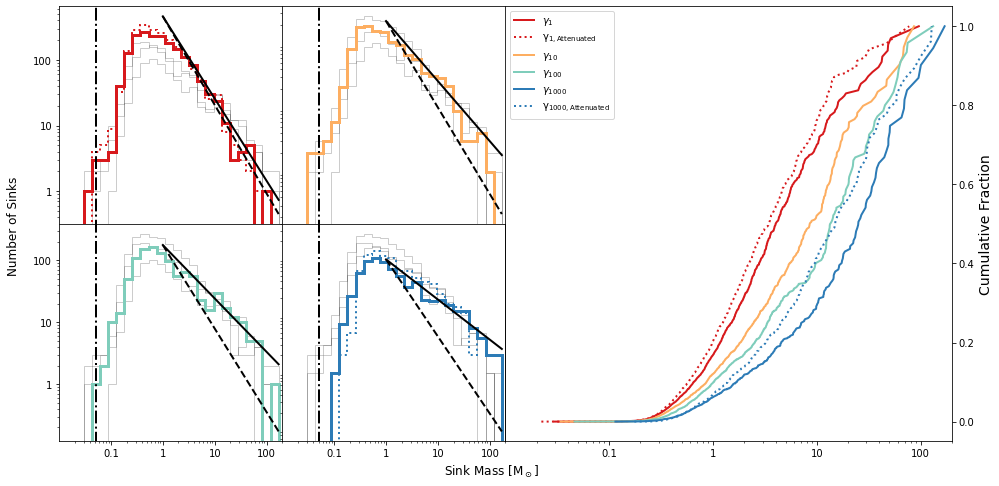

In [6]:
plt.style.use("mattStyle")

# Setup the figure and adjust
fig, axs = plt.subplot_mosaic([['upper left', 'upper center', 'right', 'right'],
                               ['lower left', 'lower center', 'right', 'right']],
                              figsize=(16, 8), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
#matplotlib.rcParams.update({'figure.dpi': 150})

axes = ["upper left", "upper center", "lower left", "lower center"]
labels = ["$\\gamma_1$", "$\\gamma_{10}$", "$\\gamma_{100}$", "$\\gamma_{1000}$"]
colors = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]
m = [m1, m2, m3, m4]
x = np.linspace(0, np.max(np.log10(uv1000s.sinkMass)), 100)

# Plot the IMFs
for i in range(4):
    thisPlot = m[i]
    notThisPlot = m[:i] + m[i+1:]

    hist = axs[axes[i]].hist(notThisPlot,  bins=bins, histtype="step", color=["k", "k", "k"], linestyle="-", alpha=0.2)
    hist = axs[axes[i]].hist(thisPlot, bins=bins, histtype="step", color=colors[i], linestyle="-", label="UV1", linewidth=3)
    
    if i == 0:
        hist = axs[axes[i]].hist(uv1crs.sinkMass, bins=bins, histtype="step", color=colors[i], linestyle=":", linewidth=2)
        hist = np.histogram(np.log10(uv1crs.sinkMass), bins=20)
        mass = hist[1][1:]
        nums = np.log10(hist[0])
        popt, pcov = curve_fit(powerLawFit, mass[mass>0], nums[mass>0])
        print(popt, np.sqrt(np.diag(pcov)))
    elif i == 3:
        hist = axs[axes[i]].hist(uv1000crs.sinkMass, bins=bins, histtype="step", color=colors[i], linestyle=":", linewidth=2)
        hist = np.histogram(np.log10(uv1000crs.sinkMass), bins=20)
        mass = hist[1][1:]
        nums = np.log10(hist[0])
        popt, pcov = curve_fit(powerLawFit, mass[mass>0], nums[mass>0])
        print(popt, np.sqrt(np.diag(pcov)))

    axs[axes[i]].set_xscale("log")
    axs[axes[i]].set_yscale("log")

    axs[axes[i]].set_xticks([0.1, 1, 10, 100])
    axs[axes[i]].set_xticklabels(["0.1", "1", "10", "100"])

    if i == 1 or i == 3:
        axs[axes[i]].set_yticks([])
    else:
        axs[axes[i]].set_yticks([1, 10, 100])
        axs[axes[i]].set_yticklabels(["1", "10", "100"])

    axs[axes[i]].vlines(jeansMass(1e8, 10), 0, 800, "k", linestyle="-.", linewidth=2)

    # Fit and plot the best fit line
    hist = np.histogram(np.log10(thisPlot), bins=20)
    mass = hist[1][1:]
    nums = np.log10(hist[0])
    popt, pcov = curve_fit(powerLawFit, mass[mass>0], nums[mass>0])
    
    axs[axes[i]].plot(10**x, (10**popt[1])*(10**x)**(-1.35), "k", linestyle="--", linewidth=2)
    axs[axes[i]].plot(10**x, 10**(powerLawFit(x, *popt)), "k", linewidth=2)
    print(popt, np.sqrt(np.diag(pcov)))

    #axs[axes[i]].text(0.1,0.5, "N = %s" % len(thisPlot))

# Plot the cumulative distributions
for i in range(4):
    mSort = np.sort(m[i])
    mCum = np.cumsum(mSort)

    # Plot the data
    axs["right"].plot(mSort, mCum/mCum[-1], color=colors[i], linewidth=2, label=labels[i])
    
    if i == 0:
        mSort = np.sort(uv1crs.sinkMass)
        axs["right"].plot(mSort, np.cumsum(mSort)/np.cumsum(mSort)[-1], color=colors[i], linestyle=":", linewidth=2, label="$\\rm \gamma_{1, Attenuated}$")
    elif i == 3:
        mSort = np.sort(uv1000crs.sinkMass)
        axs["right"].plot(mSort, np.cumsum(mSort)/np.cumsum(mSort)[-1], color=colors[i], linestyle=":", linewidth=2, label="$\\rm \gamma_{1000, Attenuated}$")
    
axs["right"].yaxis.tick_right()
axs["right"].set_ylabel("Cumulative Fraction", fontsize=14)
axs["right"].yaxis.set_label_position("right")
axs["right"].legend()
axs['right'].set_xlim(0.01, 200)

fig.supxlabel("Sink Mass $\\rm [M_\odot]$", y=0.06)
fig.supylabel("Number of Sinks", x=0.08)

### Sink Formation History

In [21]:
def readAndSave(filepath, fileName):
    # Read in the file
    data = readSinks(4, filepath)
    
    # Extract the data we want
    totalSinkMass = np.sum(data.sinkMass, axis=1)
    totalSinkMass = totalSinkMass[data.time<16]
    
    time = data.time[data.time<16] / (c.uTime() * c.year())
    
    sinkFormationRate = (totalSinkMass[2::] - totalSinkMass[0:-2]) / (2 * time[2::] - time[0:-2])
    
    np.savetxt(fileName, np.array([time[1:-1], totalSinkMass[1:-1], sinkFormationRate]).T)

In [ ]:
# Open the sink evolution files and save the sfr rates and times
readAndSave("/UV1/sink_particle_info/", "./uv1sfr.txt")
readAndSave("/UV10/sink_particle_info/", "./uv10sfr.txt")
readAndSave("/UV100/sink_particle_info/", "./uv100sfr.txt")
readAndSave("/UV1000/sink_particle_info/", "./uv1000sfr.txt")

readAndSave("/UV1r2/sink_particle_info/", "./uv1r2sfr.txt")
readAndSave("/UV10r2/sink_particle_info/", "./uv10r2sfr.txt")
readAndSave("/UV100r2/sink_particle_info/", "./uv100r2sfr.txt")
readAndSave("/UV1000r2/sink_particle_info/", "./uv1000r2sfr.txt")

In [23]:
# Load the reduced files for plotting
t1, _, s1 = np.loadtxt("./uv1sfr.txt", unpack=True)
t10, _, s10 = np.loadtxt("./uv10sfr.txt", unpack=True)
t100, _, s100 = np.loadtxt("./uv100sfr.txt", unpack=True)
t1000, _, s1000 = np.loadtxt("./uv1000sfr.txt", unpack=True)

t21, _, s21 = np.loadtxt("./uv1r2sfr.txt", unpack=True)
t210, _, s210 = np.loadtxt("./uv10r2sfr.txt", unpack=True)
t2100, _, s2100 = np.loadtxt("./uv100r2sfr.txt", unpack=True)
t21000, _, s21000 = np.loadtxt("./uv1000r2sfr.txt", unpack=True)

In [24]:
def calcRolling(s, t, window):
    df = pd.DataFrame({"t": t, "s": s})
    return df["s"].rolling(window).mean()

([<matplotlib.axis.XTick at 0x2b9e77e3cfa0>,
 [Text(400000.0, 0, '400'),
  Text(600000.0, 0, '600'),
  Text(800000.0, 0, '800'),
  Text(1000000.0, 0, '1000'),
  Text(1200000.0, 0, '1200'),
  Text(1400000.0, 0, '1400')])

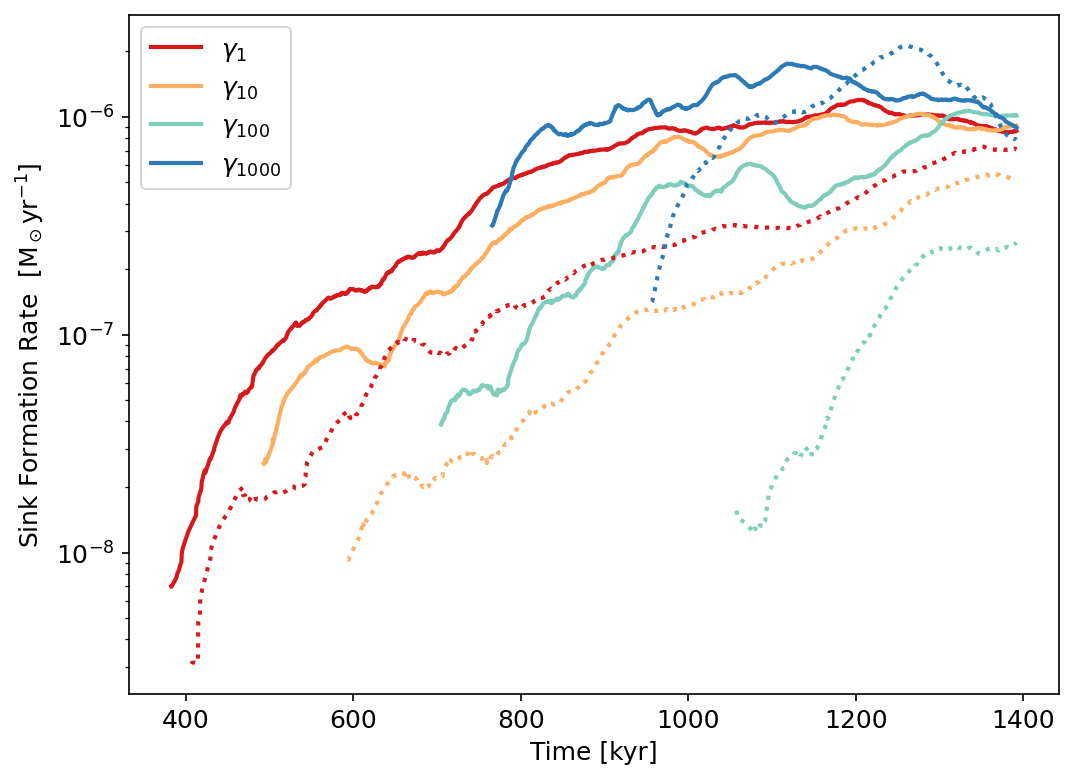

In [25]:
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.dpi': 150})

# Setup figure
plt.figure(figsize=(8,6))

# Calculate the rolling averages
window=500
sfr1 = calcRolling(s1, t1, window)
sfr10 = calcRolling(s10, t10, window)
sfr100 = calcRolling(s100, t100, window)
sfr1000 = calcRolling(s1000, t1000, window)

sfr21 = calcRolling(s21, t21, window)
sfr210 = calcRolling(s210, t210, window)
sfr2100 = calcRolling(s2100, t2100, window)
sfr21000 = calcRolling(s21000, t21000, window)

# Plot the data
plt.plot(t1, sfr1, color=c.colours()[0], label="$\\gamma_1$", linewidth=2)
plt.plot(t10, sfr10, color=c.colours()[1], label="$\\gamma_{10}$", linewidth=2)
plt.plot(t100, sfr100, color=c.colours()[3], label="$\\gamma_{100}$", linewidth=2)
plt.plot(t1000, sfr1000, color=c.colours()[4], label="$\\gamma_{1000}$", linewidth=2)

plt.plot(t21, sfr21, color=c.colours()[0], linewidth=2, linestyle=":")
plt.plot(t210, sfr210, color=c.colours()[1], linewidth=2, linestyle=":")
plt.plot(t2100, sfr2100, color=c.colours()[3], linewidth=2, linestyle=":")
plt.plot(t21000, sfr21000, color=c.colours()[4], linewidth=2, linestyle=":")

# Format the figure
plt.xlabel("Time [kyr]")
plt.ylabel("Sink Formation Rate  [$\\rm M_\odot yr^{-1}$]")
plt.legend()
plt.yscale("log")
plt.xticks([4e5, 6e5, 8e5, 10e5, 12e5, 14e5], [400, 600, 800, 1000, 1200, 1400])

### Sink Properties w/ Time

In [ ]:
# Read in the sink evolution files
uv1s = readSinks(4, "/UV1/sink_particle_info/")
uv10s = readSinks(4, "/UV10/sink_particle_info/")
uv100s = readSinks(4, "/UV100/sink_particle_info/")
uv1000s = readSinks(4, "/UV1000/sink_particle_info/")

In [ ]:
uv1crs = readSinks(4, "/UV1attenuated/sink_particle_info/")
uv1000crs = readSinks(4, "/UV1000attenuated/sink_particle_info/")

Text(0, 0.5, 'Total Number of Sinks')

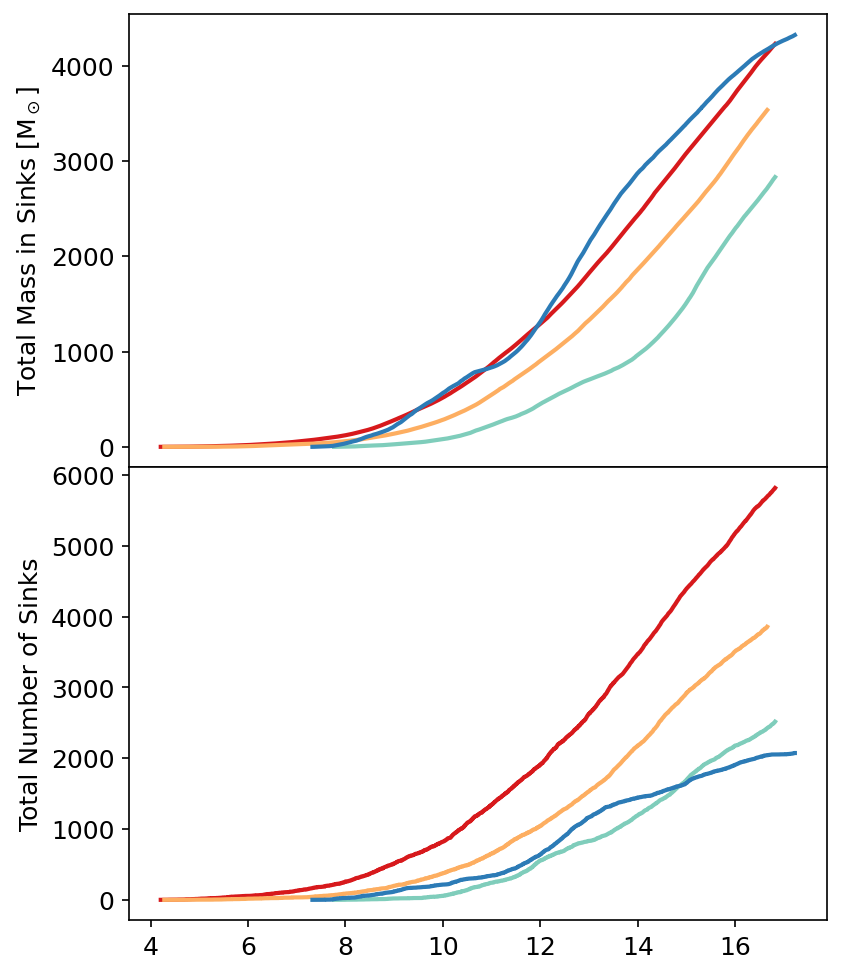

In [12]:
# Create the figure
fig, ax = plt.subplots(2,1, figsize=(6, 8), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Calculate the total sink mass
uv1mass = np.sum(uv1s.sinkMass, axis=1)
uv10mass = np.sum(uv10s.sinkMass, axis=1)
uv100mass = np.sum(uv100s.sinkMass, axis=1)
uv1000mass = np.sum(uv1000s.sinkMass, axis=1)

# Plot the lines
ax[0].plot(uv1s.time, uv1mass, c.colours()[0], linewidth=2)
ax[0].plot(uv10s.time, uv10mass, c.colours()[1], linewidth=2)
ax[0].plot(uv100s.time, uv100mass, c.colours()[3], linewidth=2)
ax[0].plot(uv1000s.time, uv1000mass, c.colours()[4], linewidth=2)

# Plot the lines
ax[1].plot(uv1s.time, uv1s.nSinks, c.colours()[0], linewidth=2)
ax[1].plot(uv10s.time, uv10s.nSinks, c.colours()[1], linewidth=2)
ax[1].plot(uv100s.time, uv100s.nSinks, c.colours()[3], linewidth=2)
ax[1].plot(uv1000s.time, uv1000s.nSinks, c.colours()[4], linewidth=2)

# Format the figure
ax[0].set_xlabel("Time")

ax[0].set_ylabel("Total Mass in Sinks [$\\rm M_\\odot$]")
ax[1].set_ylabel("Total Number of Sinks")

Text(0, 0.5, 'Change in Number of Sinks $\\rm \\frac{dN}{dt}$')

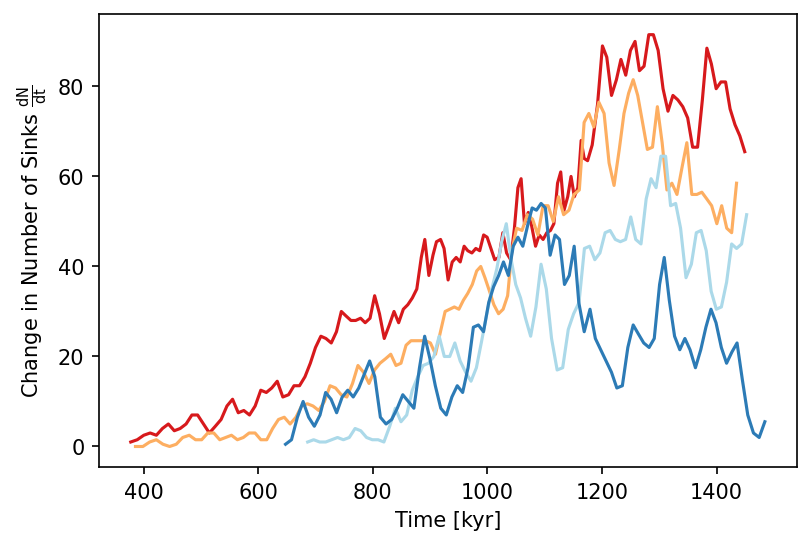

In [6]:
# Create the figure
fig, ax = plt.subplots(1,1, figsize=(6,4))

# Calculate the change in nSinks for each simulations
data = np.array([uv1s, uv10s, uv100s, uv1000s], dtype=object)
colours = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]

for i in range(len(data)):
    nS = data[i].nSinks[::100]
    tS = data[i].time[::100]

    # Calculate dN/dt
    nDot1 = (nS[2:] - nS[:-2]) / 2

    plt.plot(tS[1:-1]/c.uTime()/(1000*c.year()), nDot1, color=colours[i]) 
 
# Format the fgure   
ax.set_xlabel("Time [kyr]")
ax.set_ylabel("Change in Number of Sinks $\\rm \\frac{dN}{dt}$")

Text(0, 0.5, 'Change in Mass of Sinks $\\rm \\frac{dM}{dt}$')

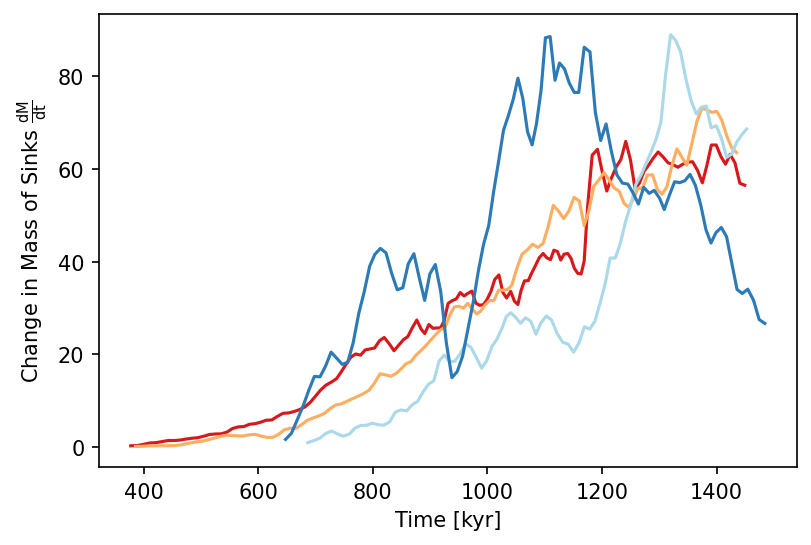

In [8]:
# Create the figure
fig, ax = plt.subplots(1,1, figsize=(6,4))

# Calculate the change in nSinks for each simulations
data = np.array([uv1s, uv10s, uv100s, uv1000s], dtype=object)
colours = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]

for i in range(len(data)):
    nS = np.sum(data[i].sinkMass, axis=1)[::100]
    tS = data[i].time[::100]

    # Calculate dN/dt
    nDot1 = (nS[2:] - nS[:-2]) / 2

    plt.plot(tS[1:-1]/c.uTime()/(1000*c.year()), nDot1, color=colours[i]) 
 
# Format the fgure   
ax.set_xlabel("Time [kyr]")
ax.set_ylabel("Change in Mass of Sinks $\\rm \\frac{dM}{dt}$")

### Nearest Neighbor At Formation

In [8]:
# Working out the distance to the nearest neighbour at each sinks formation time
def nearestSinkAtFormation(sinkData):
    # Get all of the unique sink IDs
    maxSinks = np.where(sinkData.nSinks == np.max(sinkData.nSinks))
    maxSinks = maxSinks[0]
    if len(maxSinks) != 1:
        maxSinks = maxSinks[-1]

    formationTimes = sinkData.formationTime[maxSinks]
    formationTimes = formationTimes[formationTimes != 0]

    uniqueIDs = sinkData.sinkID[maxSinks]
    if len(uniqueIDs) == 1:
        uniqueIDs = uniqueIDs[0]
    uniqueIDs = uniqueIDs[np.argsort(formationTimes)]

    formationTimes = np.sort(formationTimes)

    # Create storage arrays
    nearest = np.zeros_like(formationTimes)
    fifthNearest = np.zeros_like(formationTimes)
    tenthNearest = np.zeros_like(formationTimes)
    twentiethNearest = np.zeros_like(formationTimes)
    nearestID = np.zeros_like(formationTimes)

    # Loop through all the sinks
    for i in tqdm(range(1,len(formationTimes)-1)):
        # Get the index where this sink formed
        timeIndex = np.where(sinkData.time == formationTimes[i])

        # Get the sink data at this time
        sinkX = sinkData.sinkX[timeIndex]
        sinkY = sinkData.sinkY[timeIndex]
        sinkZ = sinkData.sinkZ[timeIndex]

        # Find the sink we're looking at
        sinkIndex = np.where(sinkData.formationOrder[timeIndex] == i+1)
        myX = sinkX[sinkIndex]
        myY = sinkY[sinkIndex]
        myZ = sinkZ[sinkIndex]

        if len(timeIndex[0]) == 0:
            pass
        else:
            # Get all the ids of the sinks
            ids = sinkData.sinkID[timeIndex][0]

            # Find every sink's distance to this
            r = np.sqrt((sinkX - myX)**2 + (sinkY - myY)**2 + (sinkZ - myZ)**2)

            # Get rid of distance to myself
            r = r[r != 0]
            rSorted = np.sort(r)

            # Assign nearest distances
            nearest[i] = rSorted[0]
            idNearest = np.where(r == nearest[i])
            nearestID[i] = ids[idNearest[0]]

            if len(r) < 5:
                fifthNearest[i] = 0
            else:
                fifthNearest[i] = rSorted[4]
                if len(r) < 10:
                    tenthNearest[i] = 0
                else:
                    tenthNearest[i] = rSorted[9]
                    if len(r) < 20:
                        twentiethNearest[i] = 0
                    else:
                        twentiethNearest[i] = rSorted[19]

    return formationTimes, nearest, fifthNearest, tenthNearest, twentiethNearest

In [9]:
# Find nearest neighbours for each cloud
_, a1, a5, a10, a20 = nearestSinkAtFormation(uv1s)
_, b1, b5, b10, b20 = nearestSinkAtFormation(uv10s)
_, c1, c5, c10, c20 = nearestSinkAtFormation(uv100s)
_, d1, d5, d10, d20 = nearestSinkAtFormation(uv1000s)

#, ac1, ac5, ac10, ac20 = nearestSinkAtFormation(uv1crs)
#_, dc1, dc5, dc10, dc20 = nearestSinkAtFormation(uv1000crs)

  0%|          | 0/2120 [00:00<?, ?it/s]

/tmp/ipykernel_18581/1115938185.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nearestID[i] = ids[idNearest[0]]
100%|██████████| 985/985 [00:00<00:00, 10447.50it/s]


In [10]:
import matplotlib.patheffects as pe

([<matplotlib.axis.XTick at 0x2af027b48100>,
 [Text(1, 0, '1'), Text(2, 0, '10'), Text(3, 0, '100'), Text(4, 0, '1000')])

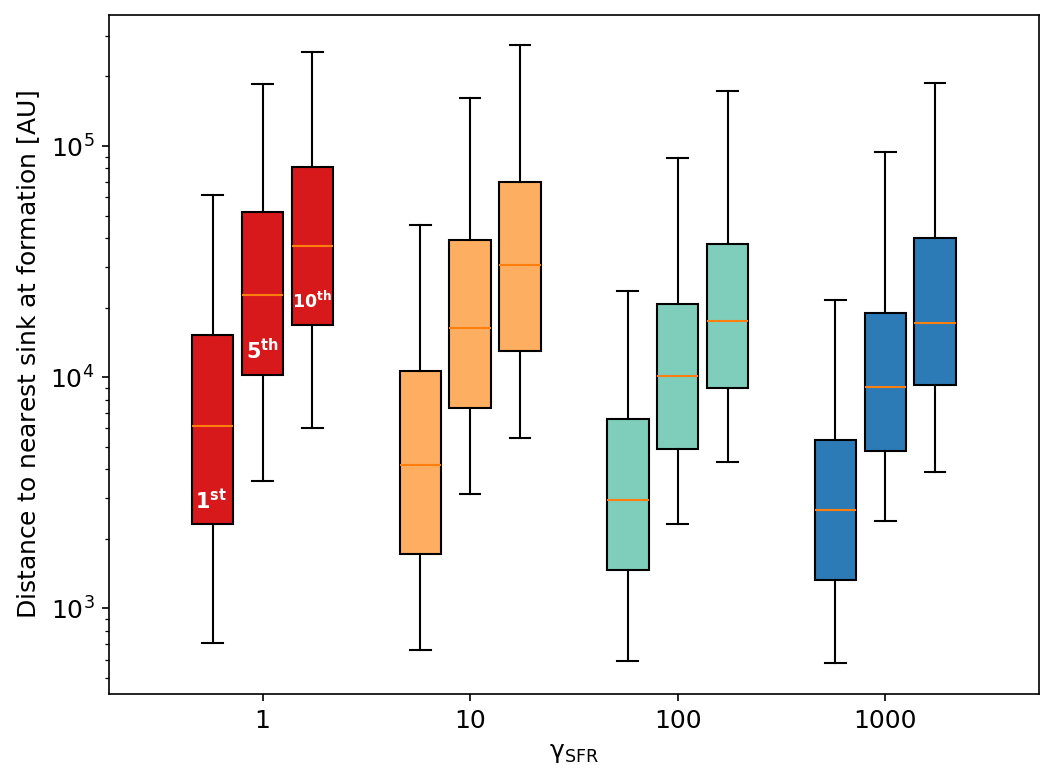

In [34]:
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.dpi': 150})

e = 1e17 / 1.5e13

near1 = [e*a1, e*b1, e*c1, e*d1] 
near5 = [e*a5, e*b5, e*c5, e*d5]
near10 = [e*a10, e*b10, e*c10, e*d10]

# Set the properties of the box plots
boxWidths = 0.2
posBase = np.linspace(1, 4, 4)

# Create the box plots
n1b = plt.boxplot(near1, widths=boxWidths, positions=posBase-1.2*boxWidths, patch_artist=True, tick_labels=["UV1", "UV10", "UV100", "UV1000"], whis=[5,95], showfliers=False)
n5b = plt.boxplot(near5, widths=boxWidths, positions=posBase, patch_artist=True, tick_labels=["UV1", "UV10", "UV100", "UV1000"], whis=[5,95], showfliers=False)
n10b = plt.boxplot(near10, widths=boxWidths, positions=posBase+1.2*boxWidths, patch_artist=True, tick_labels=["UV1", "UV10", "UV100", "UV1000"], whis=[5,95], showfliers=False)

# Colour the box plots
boxColors = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]
for bplot in a1:
    for patch, color in zip(n1b['boxes'], boxColors):
        patch.set_facecolor(color)
    for patch, color in zip(n5b['boxes'], boxColors):
        patch.set_facecolor(color)
    for patch, color in zip(n10b['boxes'], boxColors):
        patch.set_facecolor(color)
        
#plt.text(0.7, 1.5e3, "$\\rm 1^{st}$", fontsize=9, color=c.colours()[0], path_effects=[pe.withStroke(linewidth=3, foreground="white")])
#plt.text(0.95, 5e3, "$\\rm 5^{th}$", fontsize=9, color=c.colours()[0], path_effects=[pe.withStroke(linewidth=3, foreground="white")])
#plt.text(1.145, 8e3, "$\\rm 10^{th}$", fontsize=9, color=c.colours()[0], path_effects=[pe.withStroke(linewidth=3, foreground="white")])

plt.text(0.675, 2.7e3, "$\\rm \\mathbf{1^{st}}$", color="white", fontsize="small", fontweight="extra bold")#, path_effects=[pe.withStroke(linewidth=3, foreground="white")])
plt.text(0.92, 1.2e4, "$\\rm \\mathbf{5^{th}}$", color="white", fontsize="small", fontweight="extra bold")
plt.text(1.142, 2e4, "$\\rm \\mathbf{10^{th}}$", color="white", fontsize="x-small", fontweight="extra bold")


plt.ylabel("Distance to nearest sink at formation [$\\rm AU$]")
plt.yscale("log")
plt.xlabel("$\\rm \gamma_{SFR}$")
plt.xticks([1, 2, 3, 4], [1, 10, 100, 1000])

### Sink Mass Function Evolution

Text(0.04, 0.5, 'Frequency Density')

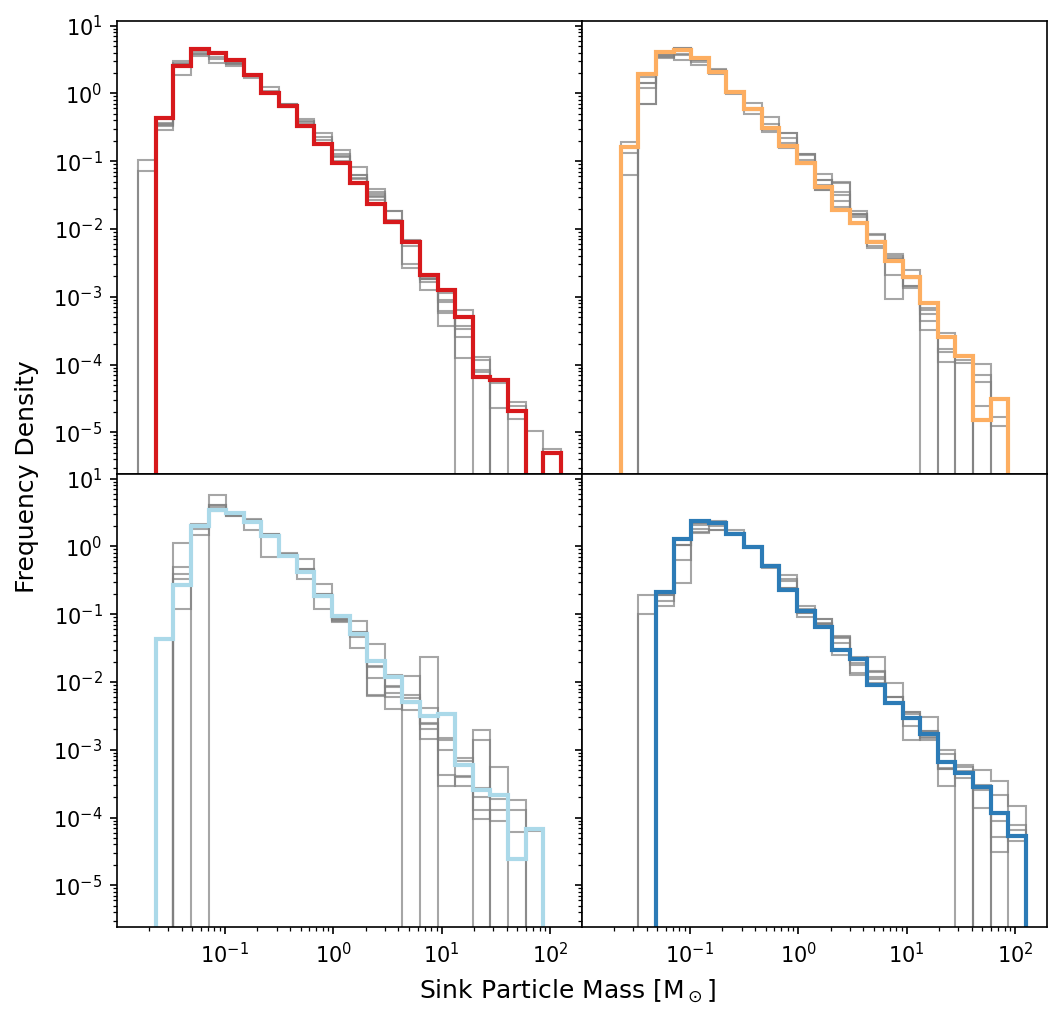

In [ ]:
# Numbers of the snapshots we want to load and mass bins
snapNums = [100, 110, 120, 130, 140, 150, 160]
bins = 10**np.linspace(-1.8, 2.1, 25)

# Setup figure
fig, ax = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

paths = np.array([[1, 10], [100, 1000]])
colours = np.array([[c.colours()[0], c.colours()[1]],[c.colours()[3], c.colours()[4]]])

for i in range(2):
    for j in range(2):
        axes = ax[i,j]

        # Loop through each snapshot and load it in
        for k in range(len(snapNums)):
            data = readSinks(1, "/UV" + str(paths[i,j]) + "/sink_snap_" + str(snapNums[k]))

            if k < len(snapNums)-1:
                axes.hist(data.sinkMass, bins=bins, histtype="step", density=True, color="gray", alpha=0.7)
            else:
                axes.hist(data.sinkMass, bins=bins, histtype="step", density=True, color=colours[i,j], linewidth=2)

        axes.set_xscale("log")
        axes.set_yscale("log")

fig.supxlabel("Sink Particle Mass $\\rm [M_\\odot]$", y=0.06)
fig.supylabel("Frequency Density", x=0.04)

### Accretion Rates

In [14]:
@jit(nopython=True)
def findAccretionRate(sinks, ids, masses, times):
    # Work out shape of the data
    dataShape = np.shape(masses)
    numSinks = np.shape(sinks)
    mAtAccrete = []
    accreteRat = []

    for i in range(numSinks[0]):
        m = []
        t = []

        # Get properties of this sinks
        for j in range(dataShape[0]):
            for k in range(dataShape[1]):
                if ids[j,k] == sinks[i]:
                    m.append(masses[j,k])
                    t.append(times[j]*np.float64(87019)) 

        mLen = np.shape(m)

        for j in range(mLen[0]):
            for k in range(j, mLen[0]):
                if m[k] > 1.1*m[j]:
                    mAbove = m[k]
                    tAbove = t[k]

                    dm = mAbove - m[j]
                    dt = tAbove - t[j]

                    mAtAccrete.append(m[j])
                    accreteRat.append(dm/dt)
                    
                    break

    mAtAccrete = np.array(mAtAccrete)
    accreteRat = np.array(accreteRat)

    return mAtAccrete, accreteRat

def getAccretionAboveMass(data, mass):
    # Get IDs of sinks that end with a particular mass
    highMassSinks = np.where(data.sinkMass[-1] > mass)
    highMassSinkIDs = data.sinkID[-1][highMassSinks]

    m, a = findAccretionRate(highMassSinkIDs, data.sinkID, data.sinkMass, data.time)

    return m, a

In [15]:
def line(x, a):
    return x * a

In [16]:
m1, a1 = getAccretionAboveMass(uv1s, 1)
m10, a10 = getAccretionAboveMass(uv10s, 1)
m100, a100 = getAccretionAboveMass(uv100s, 1)
m1000, a1000 = getAccretionAboveMass(uv1000s, 1)

#### 2D Histogram Version

[5.90537168e-06 8.07875083e-01]
[1.04450034e-05 6.27567233e-01]
[2.31321226e-05 4.54585603e-01]
[2.73226072e-05 4.35405891e-01]


Text(0.045, 0.5, 'Accretion Rate $\\rm [M_\\odot \\, yr^{-1}]$')

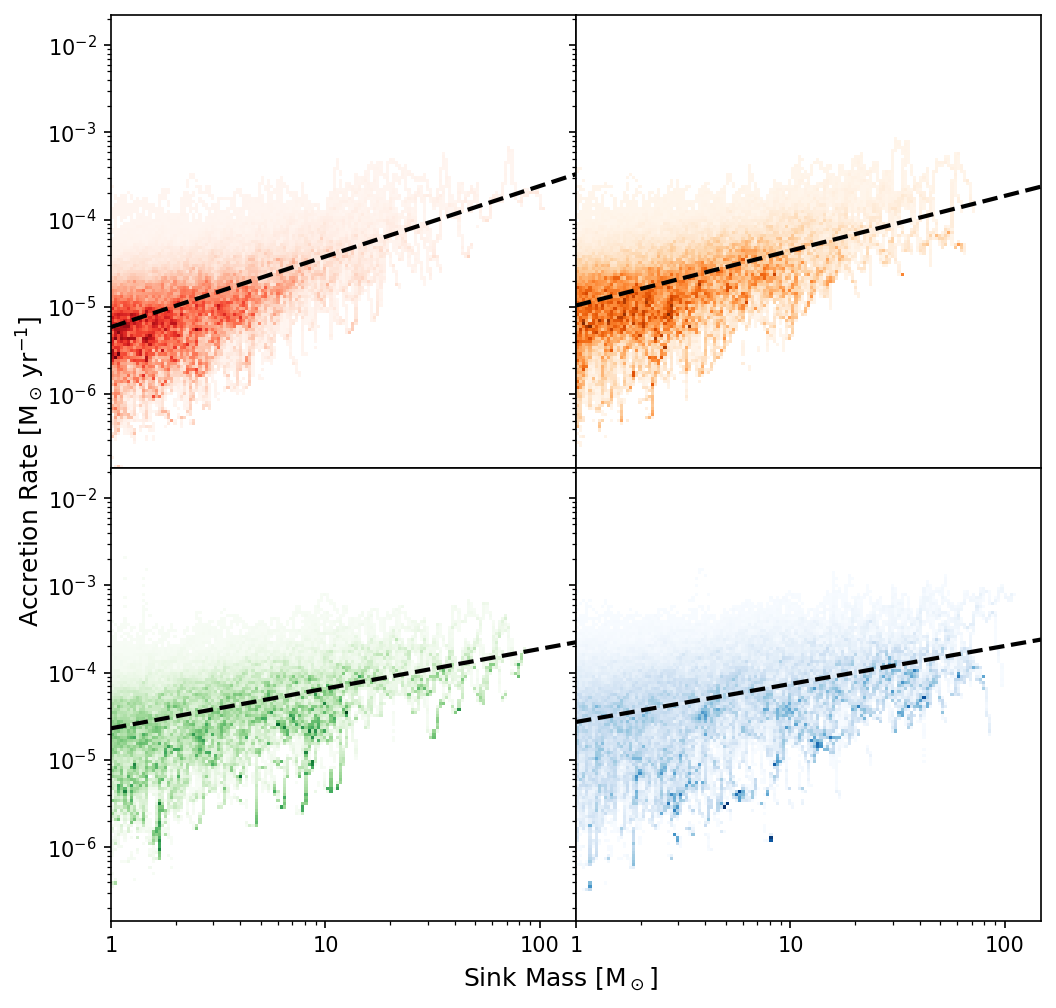

In [18]:
fig, axs = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Create xy bins
xBins = 10**np.linspace(0, np.log10(1.35*np.max(m1000)), 150)
yBins = 10**np.linspace(np.log10(np.min(a1)), np.log10(np.max(a1000)), 150)

mS = np.array([[m1, m10], [m100, m1000]], dtype=object)
aS = np.array([[a1, a10], [a100, a1000]], dtype=object)
cm = np.array([["Reds", "Oranges"], ["Greens", "Blues"]])

for i in range(2):
    for j in range(2):
        ax = axs[i,j]

        h = ax.hist2d(mS[i,j], aS[i,j], bins=(xBins, yBins), cmap=cm[i,j], cmin=0.001)
        popt, pcov = curve_fit(line, mS[i,j], aS[i,j])
        ax.plot(xBins, (xBins**popt[1])*popt[0], "k--", linewidth=2)
        print(popt)

axs[0,0].set_xscale("log")
axs[0,0].set_yscale("log")

axs[0,0].set_xticks([1, 10, 100])
axs[0,0].set_xticklabels([1, 10, 100])

fig.supxlabel("Sink Mass $\\rm [M_\\odot]$", y=0.065)
fig.supylabel("Accretion Rate $\\rm [M_\\odot \\, yr^{-1}]$", x=0.045)

#### Box Plots Version

Text(0.045, 0.5, 'Accretion Rate $\\rm [M_\\odot \\, yr^{-1}]$')

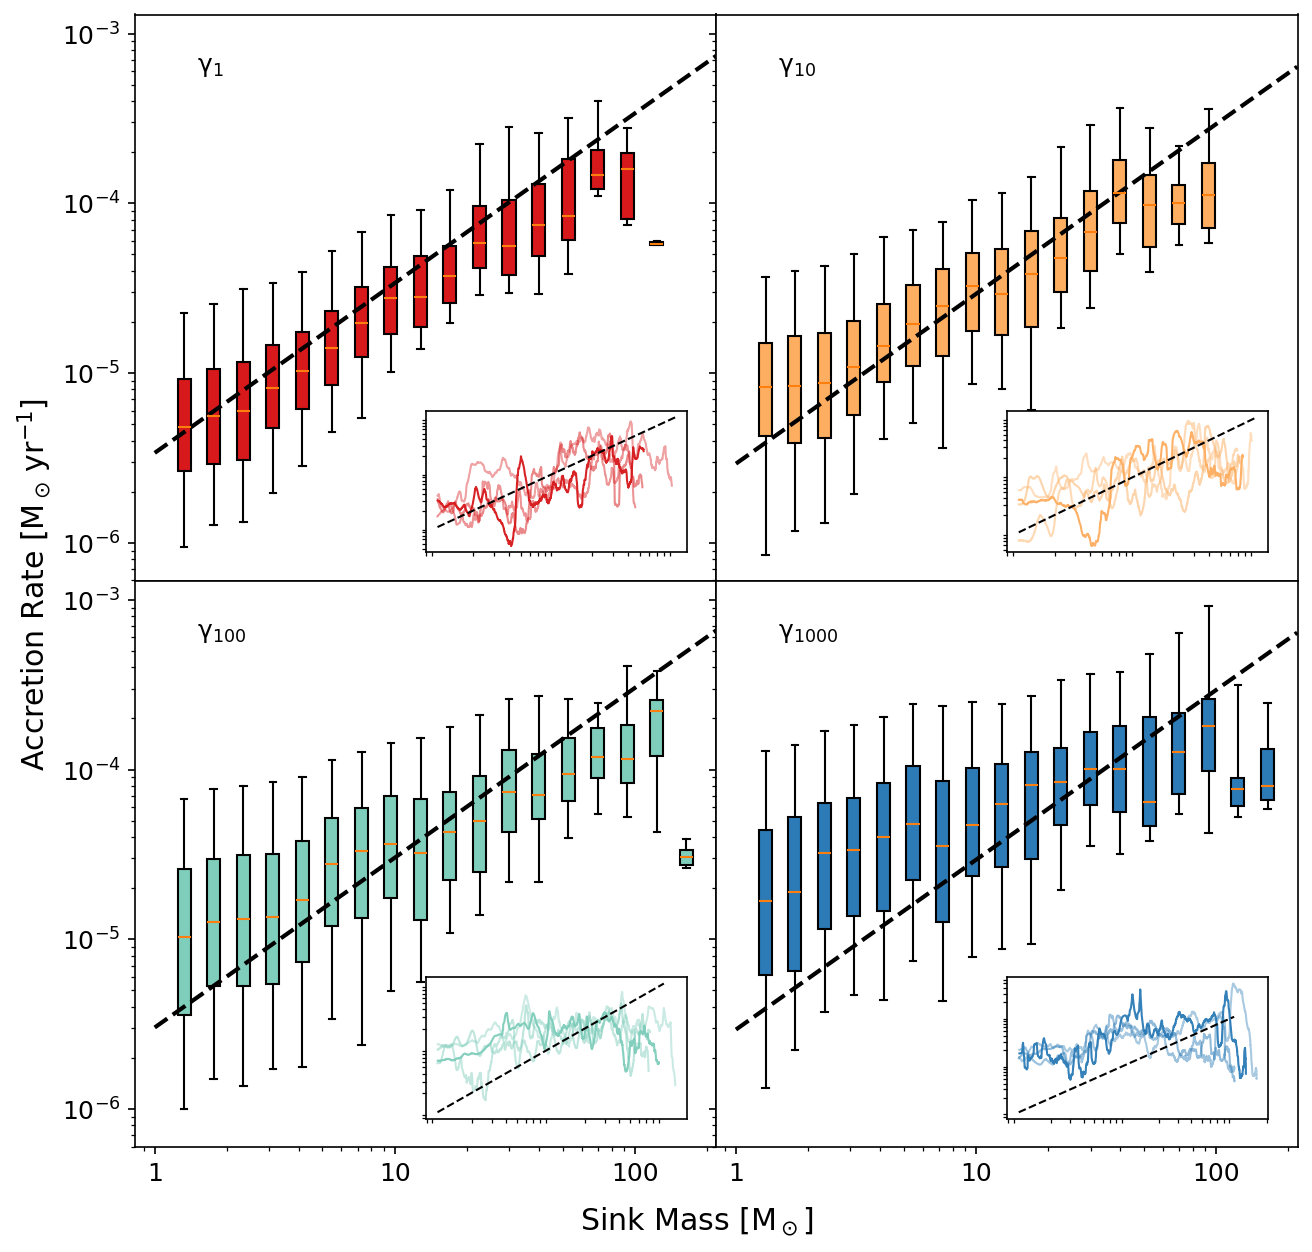

In [21]:
fig, axs = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Create xy bins
xBins = 10**np.linspace(0, np.log10(1.35*np.max(m1000)), 20)
yBins = 10**np.linspace(np.log10(np.min(a1)), np.log10(np.max(a1000)), 20)

mS = np.array([[m1, m10], [m100, m1000]], dtype=object)
aS = np.array([[a1, a10], [a100, a1000]], dtype=object)
cm = np.array([[c.colours()[0], c.colours()[1]], [c.colours()[3], c.colours()[4]]])
sinkData = np.array([[uv1s, uv10s],[uv100s, uv1000s]], dtype=object)
labels = np.array([["$\\rm \\gamma_1$", "$\\rm \\gamma_{10}$"], ["$\\rm \\gamma_{100}$", "$\\rm \\gamma_{1000}$"]])

numSinksToPlot = 5
alphas = 0.3 + 0.7 * np.random.random(numSinksToPlot)

for i in range(2):
    for j in range(2):
        ax = axs[i,j]
        
        aVals = []

        for k in range(len(xBins)-1):
            inBin = np.where((mS[i,j] > xBins[k]) & (mS[i,j] < xBins[k+1]))
            accretions = aS[i,j][inBin]
            aVals.append(accretions)
        

        a = ax.boxplot(aVals, vert=True, positions=(xBins[1:]), showfliers=False, widths=xBins[1:]/8, whis=(5,95), patch_artist=True)     
        for patch in a["boxes"]:
            patch.set_facecolor(cm[i,j]) 

        popt, pcov = curve_fit(line, mS[i,j], aS[i,j])
        ax.plot(xBins, (xBins)*popt[0], "k--", linewidth=2)
        
        ax.text(1.5, 6e-4, labels[i,j])
        
        # Inset axes for the individual tracks
        axins = ax.inset_axes([0.5,0.05,0.45,0.25])
        
        # Get the high mass sinks in this simulation
        highMassSinks = np.where(sinkData[i,j].sinkMass[-1] > 1)
        highMassSinkIDs = sinkData[i,j].sinkID[-1][highMassSinks]
        highMassSinkIDs = highMassSinkIDs[np.argsort(sinkData[i,j].sinkMass[-1][sinkData[i,j].sinkMass[-1] > 1])]

        # Loop through the sinks and get the tracks
        for k in range(numSinksToPlot):
            # Get the data for this sink
            thisSink = np.where(sinkData[i,j].sinkID == highMassSinkIDs[-k])
            mass = sinkData[i,j].sinkMass[thisSink]
            time = sinkData[i,j].time[thisSink[0]] / c.uTime() / c.year()

            # Create array for mdot
            mdot = np.zeros_like(mass)

            # Find 10% accretion rate
            for l in range(len(mass)):
                massAbove = mass[mass>mass[l]*1.1]
                timeAbove = time[mass>mass[l]*1.1]

                if len(massAbove) == 0:
                    break
                else:
                    dm = massAbove[0] - mass[l]
                    dt = timeAbove[0] - time[l]

                    mdot[l] = dm/dt
            
            # Get rid of any zero values
            mass = mass[mdot != 0]
            mdot = mdot[mdot != 0]

            axins.plot(mass[mass>1], mdot[mass>1], label="10 % Increase", color=cm[i,j], alpha=alphas[k], linewidth=1) 
            
        # Plot a 1:1 line
        x = 10**np.linspace(0, 2, 100)
        axins.plot(x, 1e-5*x, "k--", linewidth=1)
        
        axins.set_yscale("log")
        axins.set_xscale("log")
        axins.set_xticks([])
        axins.set_yticks([])

axs[0,0].set_xscale("log")
axs[0,0].set_yscale("log")

axs[0,0].set_xticks([1, 10, 100])
axs[0,0].set_xticklabels([1, 10, 100])

fig.supxlabel("Sink Mass $\\rm [M_\\odot]$", y=0.065)
fig.supylabel("Accretion Rate $\\rm [M_\\odot \\, yr^{-1}]$", x=0.045)

### Singular Accretion Rate Tracks

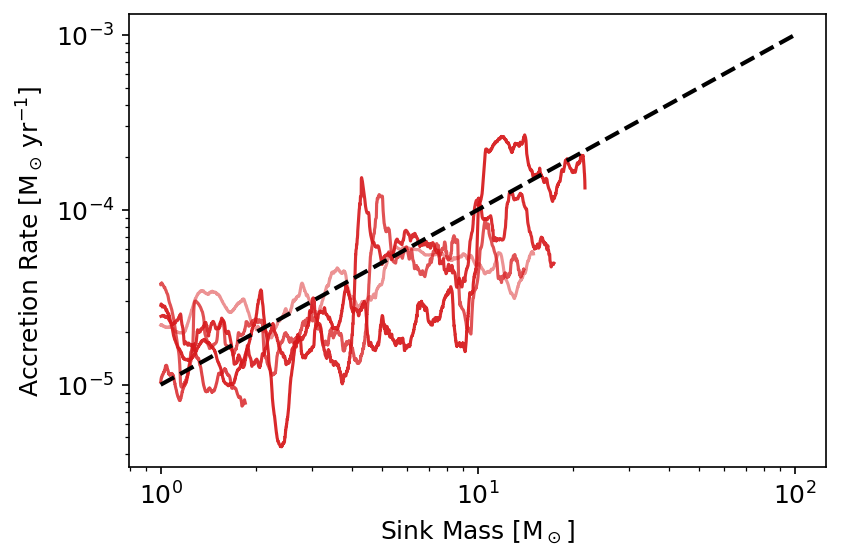

In [46]:
# Get IDs of sinks that end with a particular mass
highMassSinks = np.where(uv1s.sinkMass[-1] > 2)
highMassSinkIDs = uv1s.sinkID[-1][highMassSinks]
highMassSinkIDs = highMassSinkIDs[np.argsort(uv1s.sinkMass[-1][uv1s.sinkMass[-1] > 2])]

# Create the figure
fig, ax = plt.subplots(1,1, figsize=(6, 4))

numSinks = 5

alphas = 0.3 + 0.7 * np.random.random(numSinks)

# Plot the 10% accretion rates for each of the sinks
for j in range(numSinks):
    # Get the data for this sink
    thisSink = np.where(uv1s.sinkID == highMassSinkIDs[-j])
    mass = uv1s.sinkMass[thisSink]
    time = uv1s.time[thisSink[0]] / c.uTime() / c.year()

    # Create array for mdot
    mdot = np.zeros_like(mass)

    # Find 10% accretion rate
    for i in range(len(mass)):
        massAbove = mass[mass>mass[i]*1.1]
        timeAbove = time[mass>mass[i]*1.1]

        if len(massAbove) == 0:
            break
        else:
            dm = massAbove[0] - mass[i]
            dt = timeAbove[0] - time[i]

            mdot[i] = dm/dt
    
    # Get rid of any zero values
    mass = mass[mdot != 0]
    mdot = mdot[mdot != 0]

    ax.plot(mass[mass>1], mdot[mass>1], label="10 % Increase", color=c.colours()[0], alpha=alphas[j])

# Plot a 1:1 line
x = 10**np.linspace(0, 2, 100)
ax.plot(x, 1e-5*x, "k--", linewidth=2)

# Format the figure
ax.set_xlabel("Sink Mass [$\\rm M_\\odot$]")
ax.set_ylabel("Accretion Rate [$\\rm M_\\odot \\, yr^{-1}$]")
ax.set_yscale("log")
ax.set_xscale("log")

Text(0.06, 0.5, 'Accretion Rate [$\\rm M_\\odot \\, yr^{-1}$]')

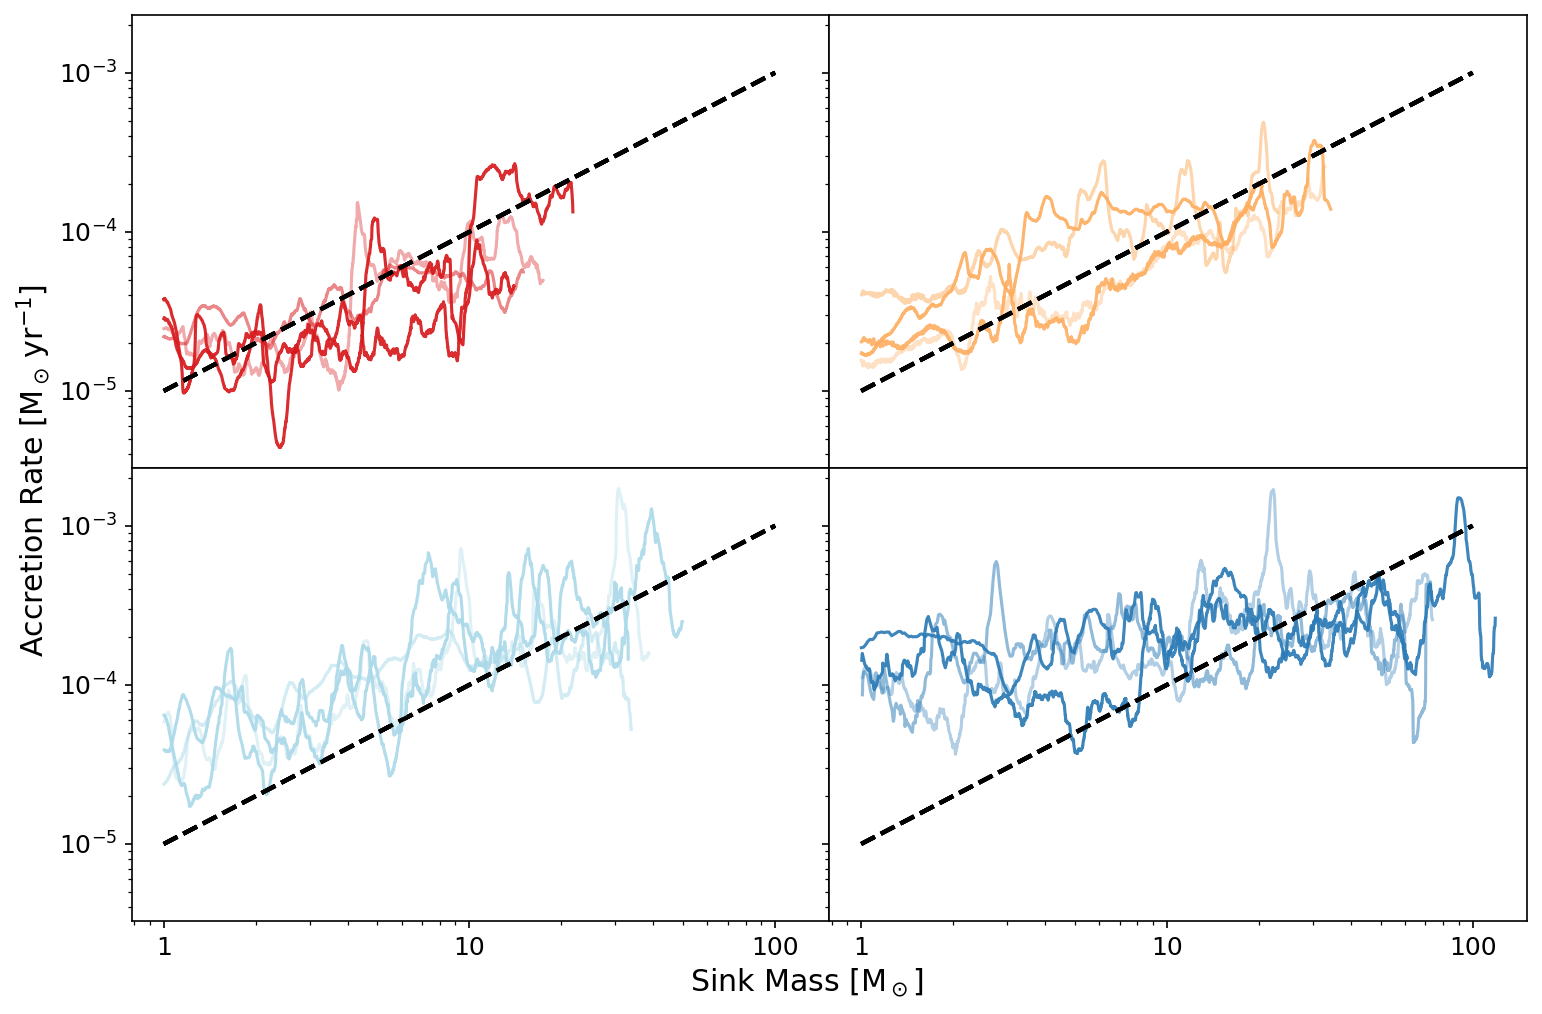

In [47]:
# Create the figure
fig, axs = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Arrays that contain each simulations data
sinkData = np.array([[uv1s, uv10s],[uv100s, uv1000s]], dtype=object)
colours = np.array([[c.colours()[0], c.colours()[1]], [c.colours()[3], c.colours()[4]]])

numSinksToPlot = 5
alphas = 0.3 + 0.7 * np.random.random(numSinks)

# Loop through each panel
for i in range(2):
    for j in range(2):
        # Get the high mass sinks in this simulation
        highMassSinks = np.where(sinkData[i,j].sinkMass[-1] > 1)
        highMassSinkIDs = sinkData[i,j].sinkID[-1][highMassSinks]
        highMassSinkIDs = highMassSinkIDs[np.argsort(sinkData[i,j].sinkMass[-1][sinkData[i,j].sinkMass[-1] > 1])]

        # Loop through the sinks and get the tracks
        for k in range(numSinksToPlot):
            # Get the data for this sink
            thisSink = np.where(sinkData[i,j].sinkID == highMassSinkIDs[-k])
            mass = sinkData[i,j].sinkMass[thisSink]
            time = sinkData[i,j].time[thisSink[0]] / c.uTime() / c.year()

            # Create array for mdot
            mdot = np.zeros_like(mass)

            # Find 10% accretion rate
            for l in range(len(mass)):
                massAbove = mass[mass>mass[l]*1.1]
                timeAbove = time[mass>mass[l]*1.1]

                if len(massAbove) == 0:
                    break
                else:
                    dm = massAbove[0] - mass[l]
                    dt = timeAbove[0] - time[l]

                    mdot[l] = dm/dt
            
            # Get rid of any zero values
            mass = mass[mdot != 0]
            mdot = mdot[mdot != 0]

            axs[i,j].plot(mass[mass>1], mdot[mass>1], label="10 % Increase", color=colours[i,j], alpha=alphas[k]) 
            
            # Plot a 1:1 line
            x = 10**np.linspace(0, 2, 100)
            axs[i,j].plot(x, 1e-5*x, "k--", linewidth=2)
 
# Format Figure            
axs[0,0].set_xscale("log")
axs[0,0].set_yscale("log")

axs[1,1].set_xticks([1,10,100])
axs[1,1].set_xticklabels(["1", "10", "100"])

fig.supxlabel("Sink Mass [$\\rm M_\\odot$]", y=0.06)
fig.supylabel("Accretion Rate [$\\rm M_\\odot \\, yr^{-1}$]", x=0.06)

In [3]:
# Calculate the time it takes to accrete 10% of a sinks mass, as well as the instantaneous accretion rate 
def timeToAccreteSingular(formationMass, sinkMass, time, sinkID, id):
    # Selecting our masses and times 
    indicies = np.where(sinkID == id)
    masses = sinkMass[indicies]
    times = time[indicies[0]] / (c.uTime() * c.year())

    # Working out 10% of each mass
    frac = masses * 0.1

    # Array to store the time
    timeToAccrete = np.zeros_like(frac)
    instAccretion = np.zeros_like(frac)
    massAtAccrete = np.zeros_like(frac)

    # Looping through each
    for i in range(len(frac)):
        # Getting the range where we've grown by 10%
        m = masses[masses > masses[i]*1.1]
        t = times[masses > masses[i]*1.1]

        # Passing the zero values
        if len(m) == 0:
            pass
        else:
            # Selecting the first time its over 10%
            t = t[0] - times[i]

            # Storing the time
            timeToAccrete[i] = t

            # Storing the instantaneous accretion rate
            instAccretion[i] = (m[0] - masses[i])/t

            # Storing the mass at this time
            massAtAccrete[i] = m[0]

    # Ignoring null values
    timeToAccrete = timeToAccrete[timeToAccrete > 0]
    instAccretion = instAccretion[instAccretion > 0]
    massAtAccrete = massAtAccrete[massAtAccrete > 0]

    return timeToAccrete, instAccretion, massAtAccrete